<a href="https://colab.research.google.com/github/seemazml/Melanoma_Detection_Neural_Network/blob/main/Seema_Zaher_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from glob import glob

In [ ]:
## Mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2248
118


### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2248 files belonging to 9 classes.
Using 1799 files for training.


In [ ]:
## Validation dataset here
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2248 files belonging to 9 classes.
Using 449 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


In [ ]:
# Keras.preprocessing
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32 
# For VGG19 the input shape and size by deafult is 244,244 and hence the same is kept
IMG_HEIGHT = 600 # This should map with the height and width of the pretrained model
IMG_WIDTH = 450 # This should map with the height and width of the pretrained model
STEPS_PER_EPOCH = np.ceil(image_count_train/BATCH_SIZE)

In [ ]:
train_data_gen = image_generator.flow_from_directory(
        directory='/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode='rgb',
        shuffle = False,
        classes = list(class_names),
        batch_size=BATCH_SIZE)

filenames = train_data_gen.filenames

Found 2248 images belonging to 9 classes.


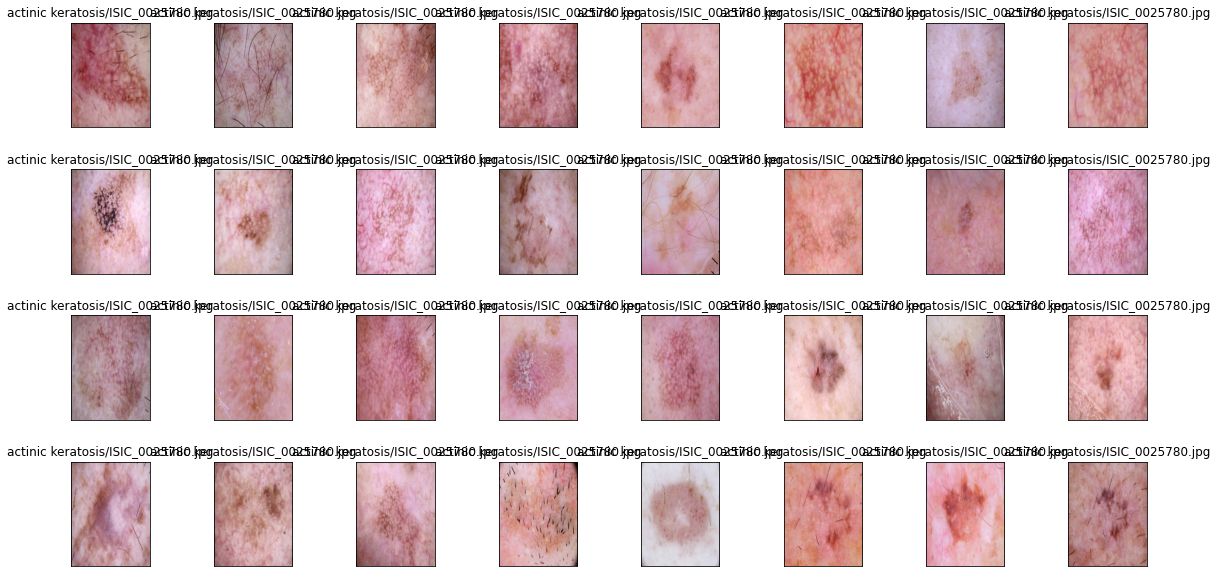

In [ ]:
import matplotlib.pyplot as plt

### Using training data to visualize
images, labels = train_data_gen.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])
    ax.set(title=filenames[image_idx])

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Lets build a basic CNN model
num_classes = 9

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(32,3, padding= 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64,3 , padding= 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    #layers.Conv2D(128,3, padding= 'same', activation='relu'),
                    #layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation= 'softmax'),
                    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Choosing an Ádam optimiser and 'Sparse Categorical Cross entropy loss function

model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss= tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 1330s 10s/step - loss: 7.8434 - accuracy: 0.1710 - val_loss: 8.2911 - val_accuracy: 0.2049
Epoch 2/20
57/57 [==============================] - 3s 61ms/step - loss: 6.7320 - accuracy: 0.1675 - val_loss: 2.1972 - val_accuracy: 0.0891
Epoch 3/20
57/57 [==============================] - 3s 59ms/step - loss: 2.1972 - accuracy: 0.0853 - val_loss: 2.1972 - val_accuracy: 0.0891
Epoch 4/20
57/57 [==============================] - 3s 60ms/step - loss: 2.1972 - accuracy: 0.0746 - val_loss: 2.1972 - val_accuracy: 0.0891
Epoch 5/20
57/57 [==============================] - 3s 59ms/step - loss: 2.1972 - accuracy: 0.0786 - val_loss: 2.1972 - val_accuracy: 0.0891
Epoch 6/20
57/57 [==============================] - 3s 59ms/step - loss: 2.1972 - accuracy: 0.0774 - val_loss: 2.1972 - val_accuracy: 0.0891
Epoch 7/20
57/57 [==============================] - 3s 60ms/step - loss: 2.1972 - accuracy: 0.0719 - val_loss: 2.1972 - val_accuracy: 0.0891
Epoch 8/20


### Visualizing training results

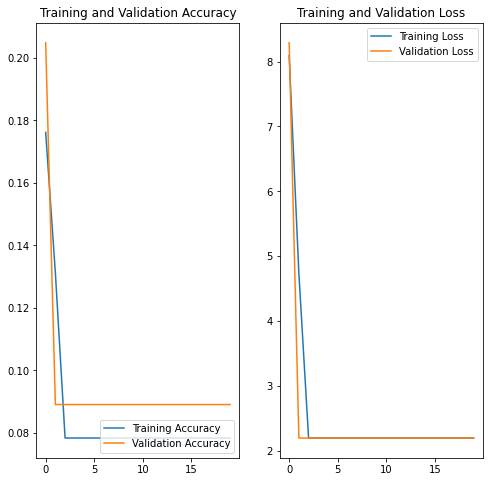

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The Training and Validation accuracies are very low at about 14%.  Lets check how to improve the performance

### We see that there is a severe class imbalance here. While Dermatofibroma and Seborrheic Keratosis have less than 100 training samples, Melanoma and Pigmented benign Keratosis have the highest (more than 400)

In [ ]:
# Data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

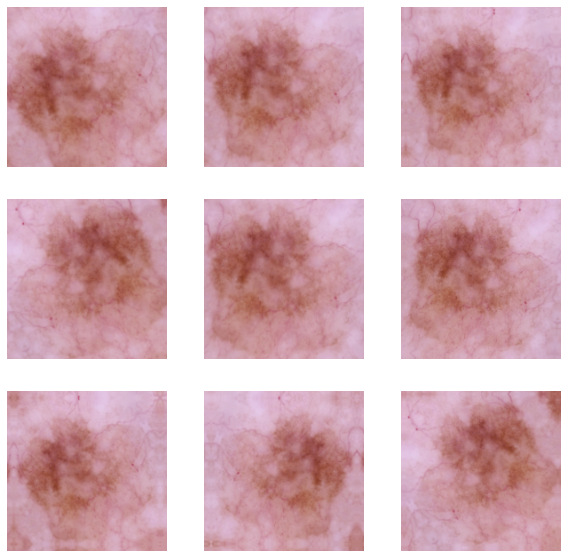

In [ ]:
# Visualizing how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# model

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

# model summary
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 64)       

### Compiling the model

In [ ]:
## Compile
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Training the model

In [ ]:
## Train model for 20 epochs
epochs = 20

history = model.fit(
    train_ds, 
    validation_data= val_ds,
     epochs= epochs
     )

Epoch 1/20
57/57 [==============================] - 6s 85ms/step - loss: 2.7093 - accuracy: 0.2113 - val_loss: 1.8924 - val_accuracy: 0.2962
Epoch 2/20
57/57 [==============================] - 5s 80ms/step - loss: 1.9352 - accuracy: 0.2835 - val_loss: 1.7111 - val_accuracy: 0.4076
Epoch 3/20
57/57 [==============================] - 5s 81ms/step - loss: 1.6774 - accuracy: 0.3843 - val_loss: 1.6106 - val_accuracy: 0.4254
Epoch 4/20
57/57 [==============================] - 5s 80ms/step - loss: 1.6345 - accuracy: 0.4230 - val_loss: 1.5448 - val_accuracy: 0.4232
Epoch 5/20
57/57 [==============================] - 5s 80ms/step - loss: 1.5039 - accuracy: 0.4615 - val_loss: 1.6908 - val_accuracy: 0.4454
Epoch 6/20
57/57 [==============================] - 5s 80ms/step - loss: 1.5339 - accuracy: 0.4603 - val_loss: 1.4334 - val_accuracy: 0.5011
Epoch 7/20
57/57 [==============================] - 5s 80ms/step - loss: 1.3834 - accuracy: 0.5105 - val_loss: 1.4944 - val_accuracy: 0.4699
Epoch 8/20
57

### Visualizing the results

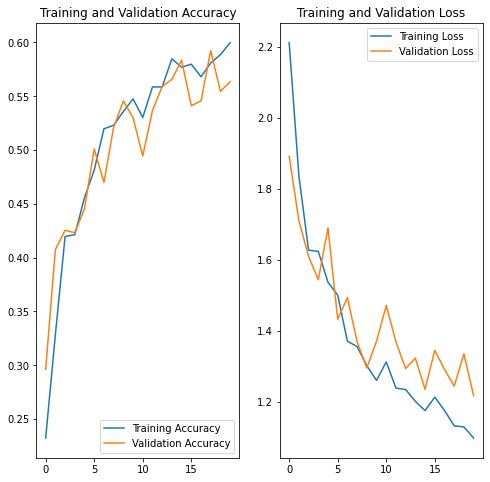

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There is a huge improvement in the accuracy

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

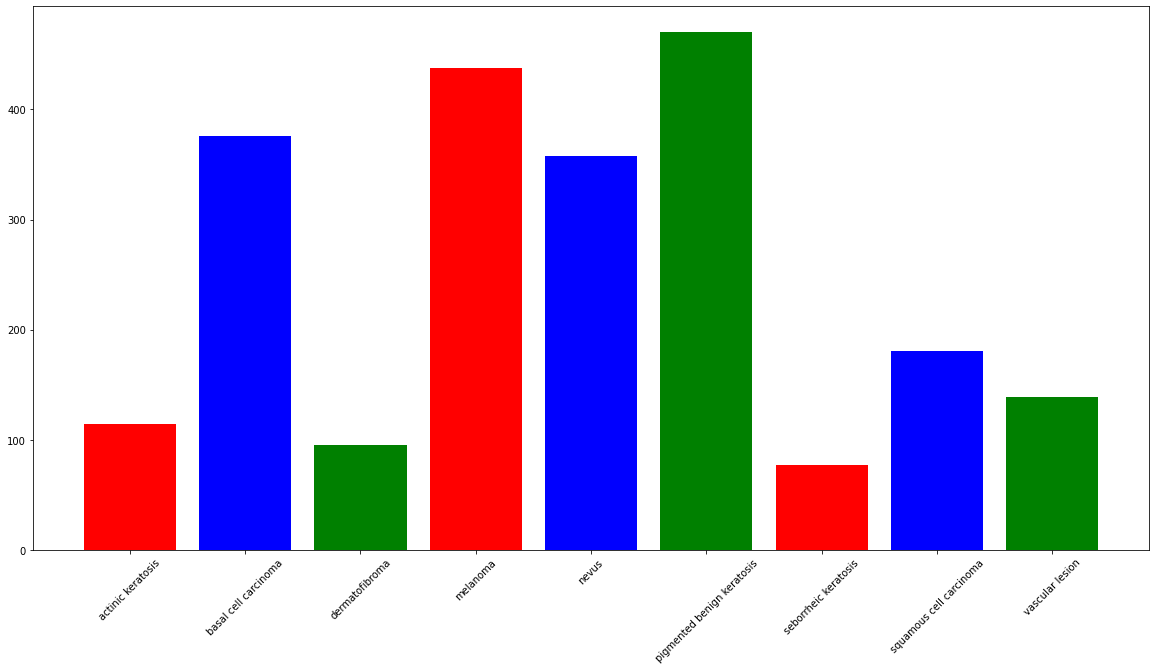

In [ ]:
### Lets check the number of training data for each of the classes
from collections import Counter

file_trim = [filename.split('/')[-2] for filename in filenames]
classes_count = Counter(file_trim)

# Plot the classes
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
plt.bar(classes_count.keys(), classes_count.values(), color=['red', 'blue', 'green'], align= 'center')

#### **Findings:** 
#### - Seborrheic keratosis class has the least number of samples
#### - Pigmented benign keratosis and Melanoma classes dominate the data in terms proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68B7151910>: 100%|██████████| 500/500 [00:22<00:00, 22.36 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F68B2FEFBD0>: 100%|██████████| 500/500 [00:22<00:00, 22.52 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F68B2FEF290>: 100%|██████████| 500/500 [00:22<00:00, 21.78 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F68B6AFCDD0>: 100%|██████████| 500/500 [01:51<00:00,  4.49 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 358 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F68B6B00850>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 470 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F68B87DD3D0>: 100%|██████████| 500/500 [00:22<00:00, 21.75 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F68B879B290>: 100%|██████████| 500/500 [00:50<00:00,  9.89 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F69602E8210>: 100%|██████████| 500/500 [00:23<00:00, 21.36 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F68B8585F10>: 100%|██████████| 500/500 [00:23<00:00, 21.29 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


# **Check for Class Imbalance once again**

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob

In [ ]:
original_path = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
original_path

In [ ]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

In [ ]:
original_dict = dict(zip(original_path,lesion_list))
original_df = pd.DataFrame(list(original_dict.items()),columns = ['Path', 'Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,melanoma
1,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,melanoma
2,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,melanoma
3,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,melanoma
4,/content/gdrive/MyDrive/Skin_cancer_ISIC_The_I...,melanoma


In [ ]:

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    970
melanoma                      938
basal cell carcinoma          876
nevus                         858
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
import shutil

In [ ]:
#Create a new destination path to merge the output files with base files
# Destination path  
train_final = pathlib.Path('/content/gdrive/MyDrive/New_Skin_cancer_ISIC/Train')

import errno

#Function to copy directories and files
def copynewdir(src, dst):
    try:
        shutil.copytree(src, dst)
    except OSError as exc: # python >2.5
        if exc.errno == errno.ENOTDIR:
            shutil.copy(src, dst)
        else: raise

In [ ]:
copynewdir(data_dir_train,train_final)

In [ ]:
#move the files from output folders into base folders and then delete the output folders
classfolders = os.listdir(train_final)            # get the list of Subfolders
op = 'output'
for classfolder in classfolders:
  cfpath = os.path.join(train_final,classfolder)
  oppath = os.path.join(cfpath,op)
  opfiles = os.listdir(oppath)
  for filename in opfiles:
    shutil.copy(os.path.join(oppath, filename), cfpath)
  
  shutil.rmtree(oppath)

In [ ]:
# count of training data
image_count_new_train = len(list(glob(os.path.join(train_final,'*','*.jpg'))))
print(image_count_new_train)

6748


In [ ]:
data_dir_train= train_final
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6748 files belonging to 9 classes.
Using 5399 files for training.


#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6748 files belonging to 9 classes.
Using 1349 files for validation.


#### Create model (including Batch normalization)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## your code goes here
# import BatchNormalization
from keras.layers.normalization import BatchNormalization

model = Sequential([
  #data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 64)       

#### Compile model

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#### Train model

In [ ]:
epochs = 30
history = model.fit(
    train_ds, 
    validation_data= val_ds,
     epochs= epochs
     )

Epoch 1/30
169/169 [==============================] - 66s 375ms/step - loss: 9.6996 - accuracy: 0.2561 - val_loss: 39.7461 - val_accuracy: 0.1231
Epoch 2/30
169/169 [==============================] - 61s 352ms/step - loss: 1.5972 - accuracy: 0.4044 - val_loss: 27.3719 - val_accuracy: 0.1290
Epoch 3/30
169/169 [==============================] - 61s 353ms/step - loss: 1.4302 - accuracy: 0.4535 - val_loss: 7.4994 - val_accuracy: 0.2128
Epoch 4/30
169/169 [==============================] - 63s 363ms/step - loss: 1.2355 - accuracy: 0.5333 - val_loss: 7.4543 - val_accuracy: 0.2016
Epoch 5/30
169/169 [==============================] - 63s 363ms/step - loss: 1.1385 - accuracy: 0.5598 - val_loss: 2.6394 - val_accuracy: 0.2891
Epoch 6/30
169/169 [==============================] - 68s 391ms/step - loss: 0.9858 - accuracy: 0.6322 - val_loss: 3.0695 - val_accuracy: 0.3314
Epoch 7/30
169/169 [==============================] - 63s 362ms/step - loss: 0.8813 - accuracy: 0.6769 - val_loss: 2.1984 - val_

#### Visualize the model results

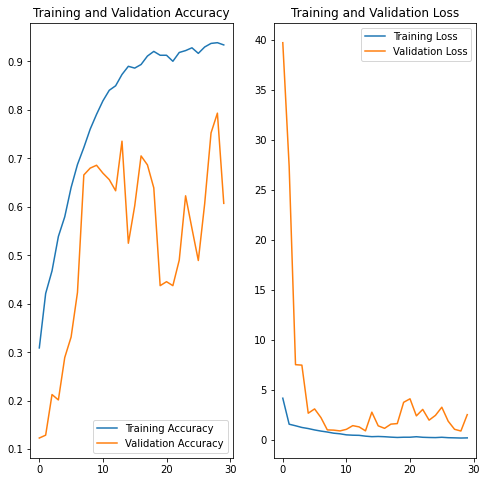

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of the results. 

1.   Got rid of underfitting
2.   Class rebalance using Augmentation helped in acheiving high accuracy and lower loss




